In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder,  MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

Next we import and inspect the data, let's see what we are dealing with.

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.set_index('Id', inplace = True)
test.set_index('Id', inplace = True)

In [3]:
categorical_features = ['MSSubClass', 'MSZoning', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
       'Foundation', 'Heating', 'CentralAir', 'Electrical', 
       'GarageType', 'PavedDrive', 'MiscFeature', 
       'SaleType', 'SaleCondition']

ordinal_features = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
                    'Functional','FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
                    'Fence']

numerical_features = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
                      'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
                      'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
                      'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
                     'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                      'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold',
                     'YrSold']

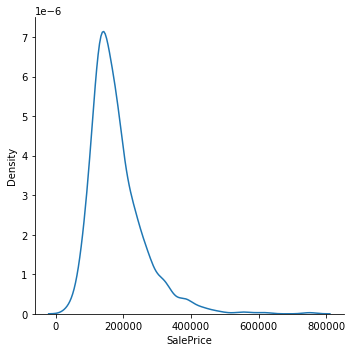

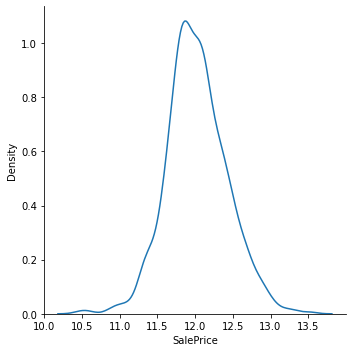

In [4]:
X = train.copy()
sns.displot(X, x="SalePrice", kind="kde")
X['SalePrice'] = np.log(X['SalePrice'])

sns.displot(X, x="SalePrice", kind="kde")

y = X.pop('SalePrice')

In [5]:
X.MSSubClass = X.MSSubClass.astype('object')
num_impute = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
obj_impute = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='None')

num_impute.fit(X[numerical_features])
obj_impute.fit(X[categorical_features+ordinal_features])

X[numerical_features] = num_impute.transform(X[numerical_features])
X[categorical_features+ordinal_features] = obj_impute.transform(X[categorical_features+ordinal_features])

In [6]:
#ord_encoder_model = OrdinalEncoder(handle_unknown='use_encoded_value')
#ord_encoder_model.fit(X[ordinal_features])

OH_encoder_model = OneHotEncoder(handle_unknown='ignore')
OH_encoder_model.fit(X[categorical_features + ordinal_features])

OneHotEncoder(handle_unknown='ignore')

In [7]:
def OH_transform(df):
    encoded = pd.DataFrame(OH_encoder_model.transform(df[categorical_features+ordinal_features]).toarray())
    df.drop(columns=categorical_features+ordinal_features, inplace=True)
    encoded.index = df.index
    encoded.columns = encoded.columns.astype(str)
    transformed = pd.concat([df, encoded], axis=1)
    return transformed

In [8]:
#X[ordinal_features] = ord_encoder_model.transform(X[ordinal_features])
X = OH_transform(X)

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Columns: 317 entries, LotFrontage to 281
dtypes: float64(317)
memory usage: 3.6 MB


In [10]:
X_trn, X_val, y_trn, y_val = train_test_split(X, y, train_size=0.75, random_state=2)

In [11]:
X_trn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1095 entries, 38 to 1193
Columns: 317 entries, LotFrontage to 281
dtypes: float64(317)
memory usage: 2.7 MB


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [13]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor(n_neighbors=5))])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('ScaledRFR', Pipeline([('Scaler', StandardScaler()),('RFR', RandomForestRegressor())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=21, shuffle=True)
    cv_results = cross_val_score(model, X_trn, y_trn, cv=kfold, scoring='neg_root_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -81807848757.030624 (97657546464.950546)
ScaledLASSO: -0.396835 (0.023052)
ScaledEN: -0.396835 (0.023052)
ScaledKNN: -0.196827 (0.010388)
ScaledCART: -0.204334 (0.015411)
ScaledGBM: -0.122407 (0.013686)
ScaledRFR: -0.138756 (0.012549)


In [14]:
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler().fit(X_trn)
rescaledX_trn = scaler.transform(X_trn)
param_grid = dict(n_estimators=np.array([50,100,200,300,400]))
model = RandomForestRegressor(random_state=21)
kfold = KFold(n_splits=10, random_state=21, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=kfold)
grid_result = grid.fit(rescaledX_trn, y_trn)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

-0.139754 (0.013584) with: {'n_estimators': 50}
-0.140269 (0.013858) with: {'n_estimators': 100}
-0.138785 (0.014007) with: {'n_estimators': 200}
-0.138735 (0.014369) with: {'n_estimators': 300}
-0.138455 (0.014298) with: {'n_estimators': 400}
Best: -0.138455 using {'n_estimators': 400}


In [15]:
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor(random_state=21, n_estimators=400)
model.fit(rescaledX_trn, y_trn)

# transform the validation dataset
rescaledX_val = scaler.transform(X_val)
predictions = model.predict(rescaledX_val)
print (mean_squared_error(y_val, predictions, squared=False))

0.17152405727218578


In [16]:
compare = pd.DataFrame({'Prediction': predictions, 'Test Data' : y_val})
compare.head(10)

,Prediction,Test Data
Id,,
504,12.513335,12.574182
102,12.081598,12.089539
609,12.528565,12.791356
1090,12.245296,12.190959
820,12.246697,12.319401
685,12.263944,12.305918
1281,12.276546,12.332705
921,12.183199,12.211060
1454,11.897529,11.344507


In [17]:
actual_y_val = np.exp(y_val)
actual_predicted = np.exp(predictions)
diff = abs(actual_y_val - actual_predicted)

compare_actual = pd.DataFrame({'Test Data': actual_y_val, 'Predicted Price' : actual_predicted, 'Difference' : diff})
compare_actual = compare_actual.astype(int)
compare_actual.head(5)

,Test Data,Predicted Price,Difference
Id,,,
504,289000,271939,17060
102,177999,176592,1407
609,359100,276112,82987
1090,197000,208000,11000
820,224000,208292,15707


In [18]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [19]:
test.MSSubClass = test.MSSubClass.astype('object')
test[numerical_features] = num_impute.transform(test[numerical_features])
test[categorical_features+ordinal_features] = obj_impute.transform(test[categorical_features+ordinal_features])

test = OH_transform(test)

In [20]:
rescaled_test = scaler.transform(test)
test_predictions = model.predict(rescaled_test)

In [21]:
print(test_predictions)

[11.72547039 11.93287156 12.08299002 ... 11.9441434  11.70216871
 12.34311815]


In [22]:
SalePrice = np.exp(test_predictions)
print(SalePrice)

[123682.16754755 152187.95176897 176838.11993821 ... 153913.09498533
 120833.48342339 229376.066658  ]


In [23]:
submission = pd.DataFrame(SalePrice, columns=['SalePrice'])
submission.index = test.index
print(submission.head())

          SalePrice
Id                 
1461  123682.167548
1462  152187.951769
1463  176838.119938
1464  180849.969694
1465  193411.940068


In [24]:
submission.to_csv('Submission Using RandomForestRegression.csv')